# ANÁLISIS EXPLORATORIO DE DATOS (EDA)

Preguntas a responder:

- ¿Cómo es el target (retorno a 7 días)?

- ¿Qué variables están fuertemente relacionadas con el target?

- ¿Cuáles son redundantes / peligrosas (leakage)?

- ¿Qué tipo de features tienen sentido para un modelo temporal?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("df_staking.csv")
df['date'] = pd.to_datetime(df['date'])

1. EDA DEL TARGET:

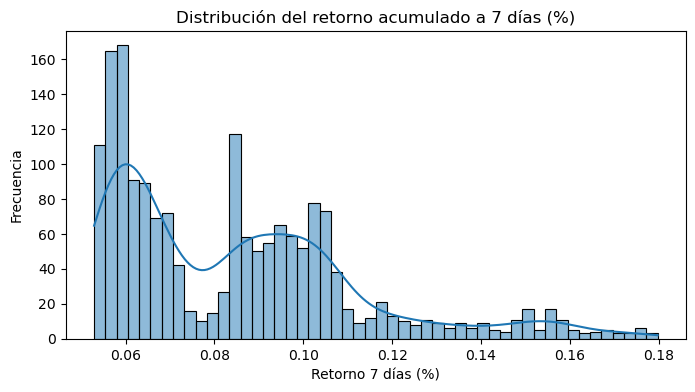

In [9]:
# Distribución del retorno a 7 días
plt.figure(figsize=(8,4))
sns.histplot(df['target_7d_return_pct'], bins=50, kde=True)
plt.title("Distribución del retorno acumulado a 7 días (%)")
plt.xlabel("Retorno 7 días (%)")
plt.ylabel("Frecuencia")
plt.show()

El retorno 7d presenta una distribución concentrada en valores bajos, especialmente entre 0.05 y 0.11.

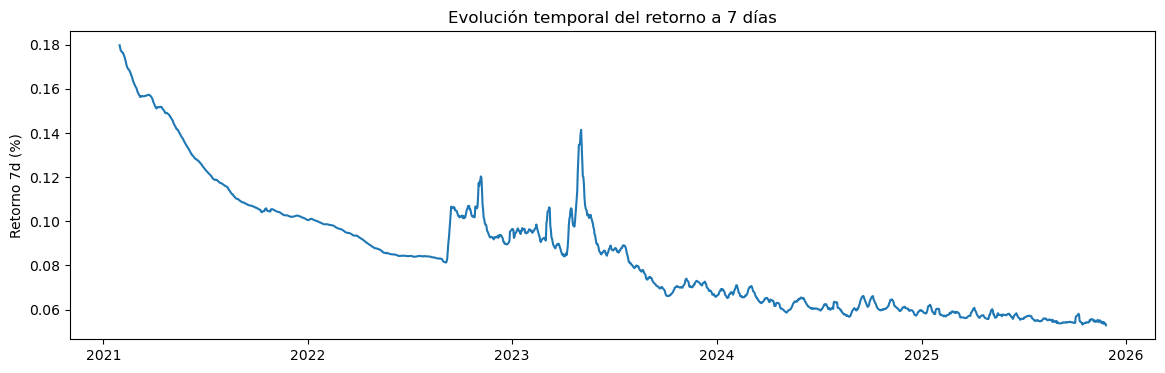

In [4]:
# Evolución temporal del target
plt.figure(figsize=(14,4))
plt.plot(df['date'], df['target_7d_return_pct'])
plt.title("Evolución temporal del retorno a 7 días")
plt.ylabel("Retorno 7d (%)")
plt.show()

Los retornos van disminuyendo a lo largo de los años, con algún pico entre finales 2022 y 2023.

In [5]:
# CORRELACIÓN CON EL TARGET (qué columnas ayudan de verdad)
numeric_cols = df.select_dtypes(include=[np.number]).columns     # Selección de columnas numéricas (sin date)

corr_target = (                               # Correlación con el target
    df[numeric_cols]
    .corr()['target_7d_return_pct']
    .sort_values(ascending=False)
)

print(corr_target)

target_7d_return_pct    1.000000
target_7d_return        1.000000
past_7d_return          0.989618
apr_roll_mean_7         0.989413
past_14d_return         0.987893
daily_return            0.987868
apr_pct                 0.987730
apr                     0.987730
apr_roll_mean_14        0.987604
apr_lag_1               0.985677
past_30d_return         0.982294
apr_lag_3               0.982248
apr_roll_mean_30        0.981745
apr_lag_7               0.976702
apr_lag_14              0.971531
past_60d_return         0.971504
apr_roll_mean_60        0.969986
apr_lag_30              0.954217
apr_lag_60              0.920409
apr_roll_std_60         0.570779
apr_roll_std_30         0.293389
apr_roll_std_14         0.128532
apr_roll_std_7          0.061352
is_weekend              0.003343
day_of_week             0.001676
month                  -0.175950
day_of_year            -0.179114
quarter                -0.181386
Name: target_7d_return_pct, dtype: float64


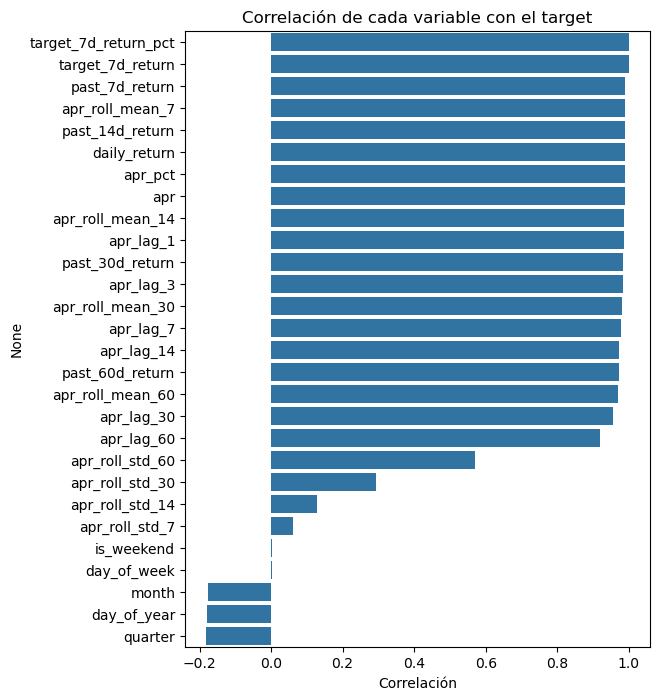

In [10]:
#Visualizar correlaciones más altas
plt.figure(figsize=(6,8))
sns.barplot(
    x=corr_target.values,
    y=corr_target.index
)
plt.title("Correlación de cada variable con el target")
plt.xlabel("Correlación")
plt.show()

- Correlaciones ~0.99 indican misma señal
- No aportan información nueva
- Generan sobreajuste

Se observa que múltiples variables derivadas del APR presentan correlaciones extremadamente altas con el target, lo que indica redundancia y riesgo de leakage.

HEATMAP: VER REDUNDANCIA ENTRE FEATURES

In [11]:
heatmap_cols = [
    'target_7d_return_pct',
    'daily_return',
    'past_7d_return',
    'past_14d_return',
    'apr_pct',
    'apr_roll_mean_7',
    'apr_roll_mean_14',
    'apr_lag_7',
    'apr_lag_14'
]

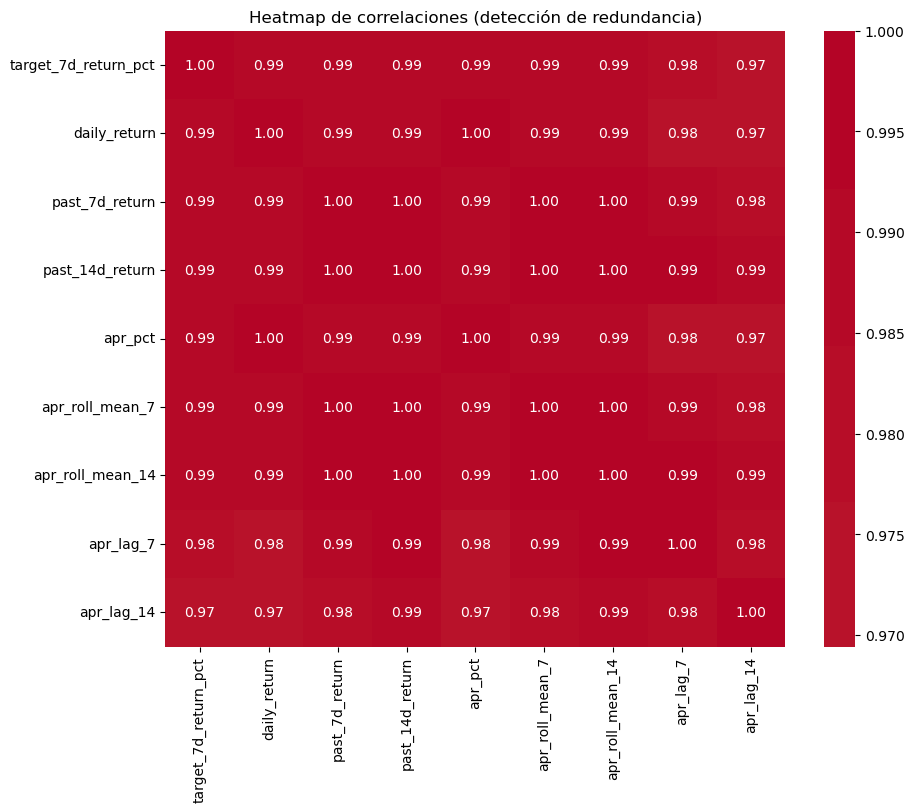

In [12]:
plt.figure(figsize=(10,8))
sns.heatmap(
    df[heatmap_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Heatmap de correlaciones (detección de redundancia)")
plt.show()

past_7d_return, apr_roll_mean_7, daily_return están pegadas (usan los mismos datos), son transformaciones de la misma señal:
- daily_return: Es simplemente el APR convertido a retorno diario. No añade información nueva, solo cambia escala.
- past_7d_return: Exactamente los mismos daily_return, solo multiplicados entre sí, en una ventana fija de 7 días.
- apr_roll_mean_7: Vuelve a usar los mismos 7 días, la misma señal base (APR).

Estas tres variables usan los mismos datos en el mismo periodo con transformaciones muy suaves, por eso el heatmap dice “sois lo mismo”.

El heatmap evidencia una alta multicolinealidad entre variables basadas en el APR, confirmando la necesidad de reducir el conjunto de features para evitar leakage.

LAS OTRAS NO ESTÁN TAN PEGADAS (miden aspectos distintos):
- apr_lag_14, apr_lag_30, apr_lag_60: Son un solo punto en el pasado, no un promedio, no un acumulado.
- apr_roll_std_* (volatilidad): Mide cuánto varía el APR, no el nivel.

Aunque múltiples variables presentan alta correlación con el target, solo aquellas que derivan directamente de la misma ventana temporal y señal base muestran multicolinealidad extrema, lo que justifica su exclusión para evitar leakage.

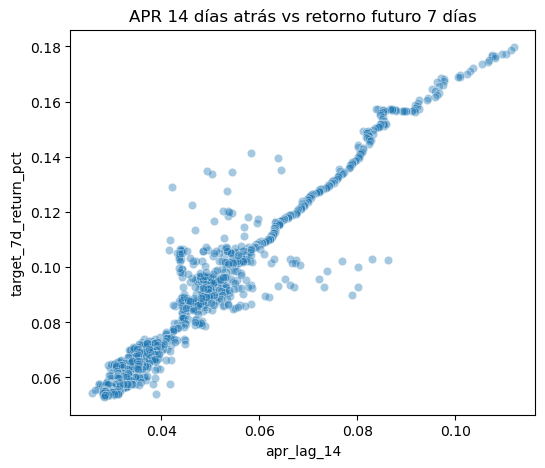

In [13]:
#RELACIÓN PASADO - FUTURO (SIN LEAKAGE): (Ahora mostramos las que sí tienen sentido)

# Lags del APR vs target
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df,
    x='apr_lag_14',
    y='target_7d_return_pct',
    alpha=0.4
)
plt.title("APR 14 días atrás vs retorno futuro 7 días")
plt.show()

Esto muestra relación indirecta, información pasada real

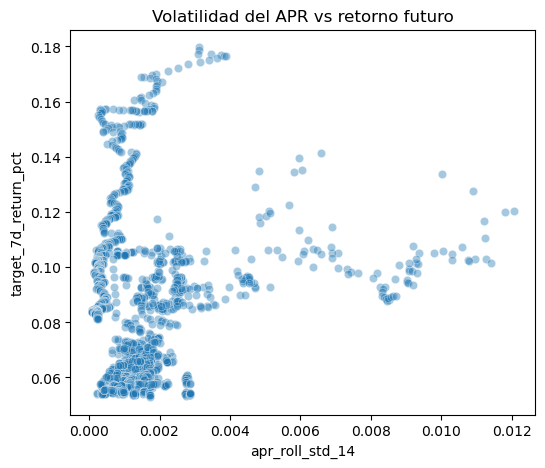

In [14]:
# Volatilidad vs target
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df,
    x='apr_roll_std_14',
    y='target_7d_return_pct',
    alpha=0.4
)
plt.title("Volatilidad del APR vs retorno futuro")
plt.show()

VARIABLES TEMPORALES:

In [17]:
temporal_cols = ['day_of_week', 'month', 'quarter', 'day_of_year', 'is_weekend']

corr_temporal = df[temporal_cols + ['target_7d_return_pct']].corr()['target_7d_return_pct']
print(corr_temporal)

day_of_week             0.001676
month                  -0.175950
quarter                -0.181386
day_of_year            -0.179114
is_weekend              0.003343
target_7d_return_pct    1.000000
Name: target_7d_return_pct, dtype: float64


- day_of_week: Casi cero, el día de la semana no afecta al APR.
- month: Muy baja negativa, cambios estacionales mínimos.
- quarter: Similar a month, poca señal real.
- day_of_year: Picos o tendencias anuales muy débiles.
- is_weekend: Casi cero, fines de semana irrelevantes.

Todas estas variables temporales tienen casi cero correlación lineal con el target: no aportan información relevante. Mantenerlas solo añadiría ruido y podría confundir al modelo.

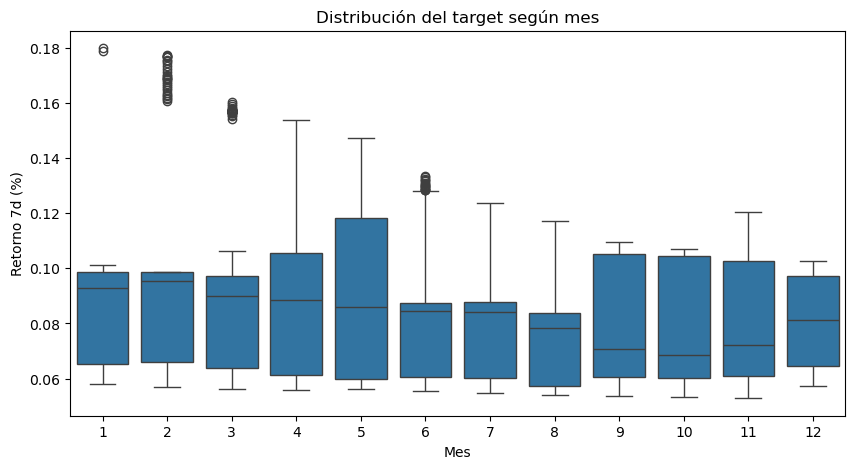

In [19]:
plt.figure(figsize=(10,5))
sns.boxplot(x='month', y='target_7d_return_pct', data=df)
plt.title("Distribución del target según mes")
plt.xlabel("Mes")
plt.ylabel("Retorno 7d (%)")
plt.show()

Para detectar estacionalidad anual:
- Mayo es el mes donde mayor retorno.
- Junio, Julio y Agosto (verano) donde menor.
- Mejora a partir de Septiembre hasta final de año.

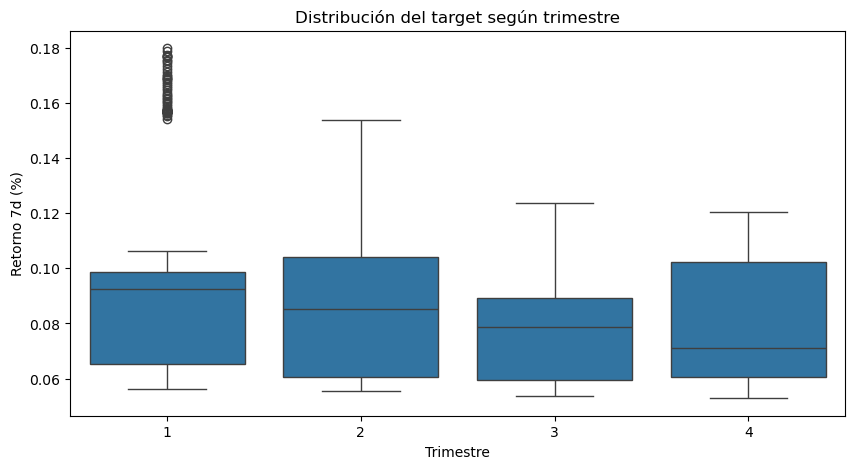

In [26]:
plt.figure(figsize=(10,5))
sns.boxplot(x='quarter', y='target_7d_return_pct', data=df)
plt.title("Distribución del target según trimestre")
plt.xlabel("Trimestre")
plt.ylabel("Retorno 7d (%)")
plt.show()

Segundo trimestre el de mayor retorno, seguido del 4 trimestre. El 3 trimestre es el de menor retorno.

CONCLUSIÓN: dejar "quarter" y eliminar "month", porque con el trimestre ya capturas la estacionalidad importante sin sobrecargar el modelo.

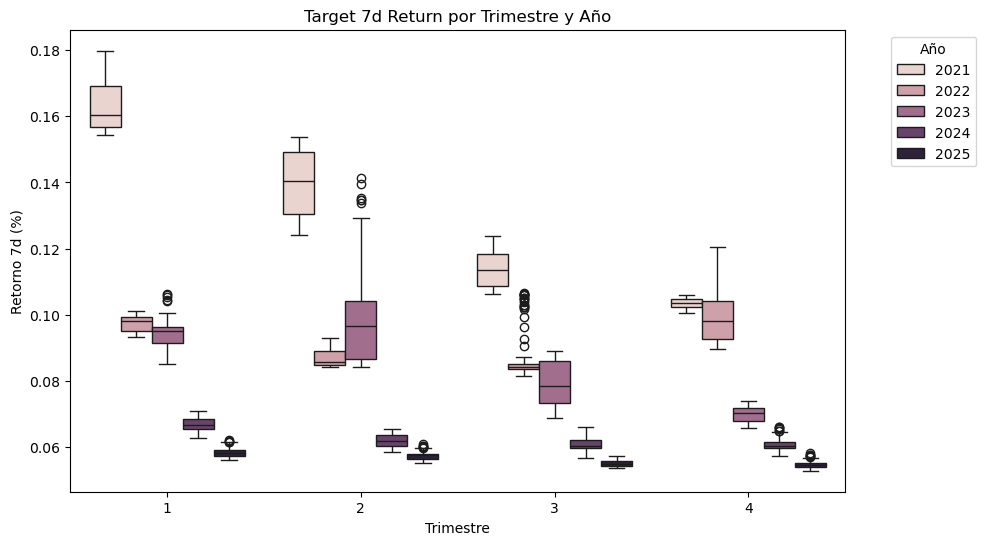

In [29]:
plt.figure(figsize=(10,6))
sns.boxplot(
    x='quarter', 
    y='target_7d_return_pct', 
    hue=df['date'].dt.year,  # separar por año
    data=df
)
plt.title("Target 7d Return por Trimestre y Año")
plt.xlabel("Trimestre")
plt.ylabel("Retorno 7d (%)")
plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

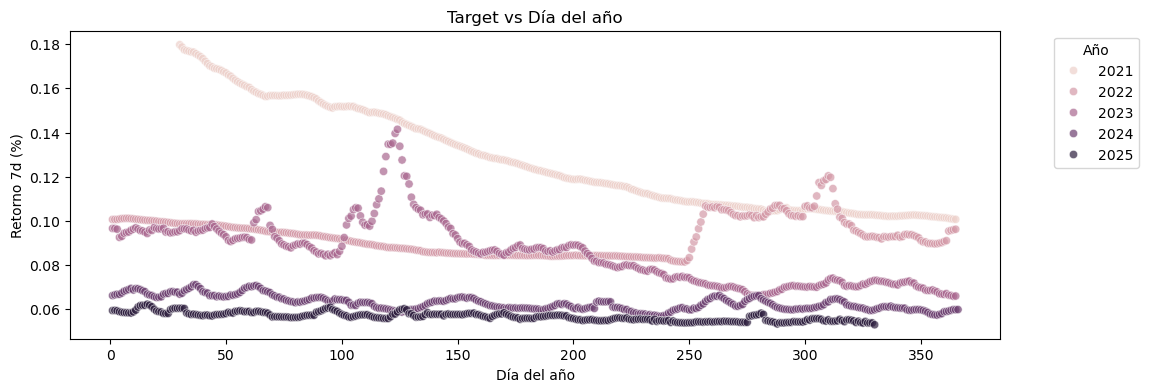

In [24]:
plt.figure(figsize=(12,4))
sns.scatterplot(x='day_of_year', y='target_7d_return_pct', hue=df['date'].dt.year, data=df, alpha=0.7)
plt.title("Target vs Día del año")
plt.xlabel("Día del año")
plt.ylabel("Retorno 7d (%)")
plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Mostrar tendencias cíclicas a lo largo del año. No se aprecia patrón de días exactos.

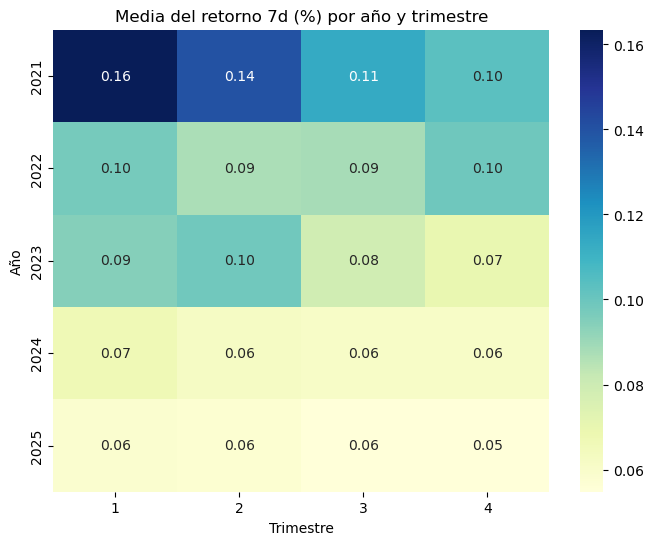

In [34]:
pivot = df.pivot_table(
    index=df['date'].dt.year, 
    columns='quarter', 
    values='target_7d_return_pct', 
    aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Media del retorno 7d (%) por año y trimestre")
plt.xlabel("Trimestre")
plt.ylabel("Año")
plt.show()

Mantener:
- Lags del APR (apr_lag_1, apr_lag_3, apr_lag_7, ...)
- Rolling means/std (apr_roll_mean_7, apr_roll_std_7, ...)
- Retornos pasados (past_7d_return, past_14d_return, ...)
- quarter
- days_since_start
- Opcional: day_of_year

Eliminar:
- day_of_week, month, is_weekend → no aportan señal relevante
- past_7d_return, apr_roll_mean_7, daily_return 